In [1]:
from __future__ import print_function
import time
import intrinio_sdk
from intrinio_sdk.rest import ApiException
from pprint import pprint
import datetime as dt
from datetime import date
from datetime import timedelta
import io
from collections import Counter
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import pandas as pd

import requests, lxml
from lxml import html

In [2]:
from Platform import Stock_Yahoo, Portfolio

### TODO List ###

STOCK
1. Implement get_performance()
    - Add holidays to daterange_iter()
2. Find an API or some source of data
    - Maybe cache data in a folder as csv's
    2.A Data
        - Allow Portfolio class to access data 
            - or maybe we need to design/think about how we want to be abstracting this data for strategies
        - How to store and how to access
    
PORTFOLIO
1. Redo Portfolio
    - buy() method
    - performance needs to show individual stocks in portfolio
    - less priority: show performance together
2. Shorting

PLATFORM
1. Make Platform
    - Testing trade logic goes here
    - Abstract on Portfolio

Once everything gets a bit more flushed out, we can parallelize our work between these classes hopefully

## CHANGE LIST ##
##### -- Anything important that people should know got changed --

4/24/19: Changed how self.prices is stored
4/24/19: Now only using the datetime.date object to represent all dates

In [3]:
data = pd.read_csv("https://query1.finance.yahoo.com/v7/finance/download/AAPL?period1=1546502400&period2=1587279600&interval=1d&events=history")

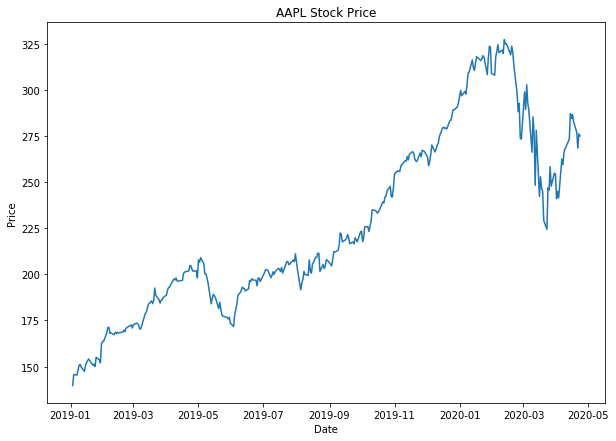

,Date,Open,High,Low,Close,Adj Close,Volume
328,2020-04-23,275.869995,281.750000,274.869995,275.029999,275.029999,31128600
327,2020-04-22,273.609985,277.899994,272.200012,276.100006,276.100006,29264300
326,2020-04-21,276.279999,277.250000,265.429993,268.369995,268.369995,45247900
325,2020-04-20,277.950012,281.679993,276.850006,276.929993,276.929993,32503800
324,2020-04-17,284.690002,286.950012,276.859985,282.799988,282.799988,53812500
323,2020-04-16,287.380005,288.200012,282.350006,286.690002,286.690002,39281300
322,2020-04-15,282.399994,286.329987,280.630005,284.429993,284.429993,32788600
321,2020-04-14,280.000000,288.250000,278.049988,287.049988,287.049988,48748700
320,2020-04-13,268.309998,273.700012,265.829987,273.250000,273.250000,32755700
319,2020-04-09,268.700012,270.070007,264.700012,267.989990,267.989990,40529100


KeyError: datetime.date(2019, 1, 21)

In [4]:
appl2 = Stock_Yahoo(ticker="AAPL", start_date=date(2019, 1, 3), end_date=date.today())
appl2.display_close_price()
appl2.display_df(10)
appl2.get_performance()

In [ ]:
testport = Portfolio()
testport.buy('AAPL', start=date(2020, 1, 3))
testport.buy('MSFT', start=date(2019, 4, 20))
testport.display_performance()

In [ ]:
# class Stock:
#     def __init__(self, ticker, start_date=date.today(), end_date=date.today(), frequency='daily', page_size=100):
#         intrinio_sdk.ApiClient().configuration.api_key['api_key'] = 'OmEzMWY4NDEzMzRlOGM3Y2ZjNmY3ZjAwZWRmZWI2MTIy'
        
#         self.ticker = ticker
#         self.start_date = start_date
#         self.end_date = end_date
#         self.frequency = frequency
#         self.security_api = intrinio_sdk.SecurityApi()
#         self.api_response = self.security_api.get_security_stock_prices(
#             ticker, start_date=start_date, end_date=end_date, 
#             frequency=frequency, page_size=int((end_date - start_date).days), next_page='')
#         self.date_range_iter = self.daterange(start_date, end_date)
#         self.prices = self.api_response.stock_prices_dict
#         self.start_price = self.api_response.stock_prices_dict[0]['adj_close']
#         self.end_price = self.api_response.stock_prices_dict[-1]['adj_close']
    
#     def display_close_price(self):
#         plt.title(self.ticker + " Stock Price")
#         close_prices = []
#         date = []
#         #### CHANGED ####
#         prices_df = pd.DataFrame(self.prices)
#         close_prices = prices_df['adj_close']
#         date = prices_df['date']
#         #### CHANGED ####
#         plt.plot(date, close_prices)
#         plt.xlabel("Date")
#         plt.ylabel("Price")
#         plt.show()
# #         #TODO: add start and end date arguments 
    
#     def get_stock_price_dict(self):
#         return self.api_response.stock_prices_dict
    
#     def get_api_response(self):
#         return self.api_response
    
# #     def start_price(self):
# #         return self.api_response.stock_prices_dict[0]['close']
    
# #     def end_price(self):
# #         return self.api_response.stock_prices_dict[-1]['close']
    
#     def get_performance(self, start=None, end=None):
#         if (start == None):
#             start = self.start_date
#         if (end == None):
#             end = self.end_date
        
#         max_ind = len(self.prices)
#         curr_ind = 0
#         gains = []

#         for date in self.daterange(start, end):
#             if ((date - self.start_date).total_seconds() < 0):
#                 gains.append(0)
#             elif ((self.end_date - date).total_seconds() < 0):
#                 gains.append(0)
#             elif (curr_ind >= max_ind):
#                 gains.append(0)
#             else:
#                 gains.append(self.prices[curr_ind]['adj_close'] - self.start_price)
#                 curr_ind += 1
#         return np.array(gains)
    
#     def daterange(self, start_date, end_date):
#         delta = timedelta(days=1)
#         while start_date <= end_date:
#             if (start_date.weekday() >= 5):
#                 start_date += delta
#                 continue
#             yield start_date
#             start_date += delta
    